In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import joblib

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16,10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
df = pd.read_csv('airbnb_nyc_2019.csv')

In [4]:
df.shape

(48895, 16)

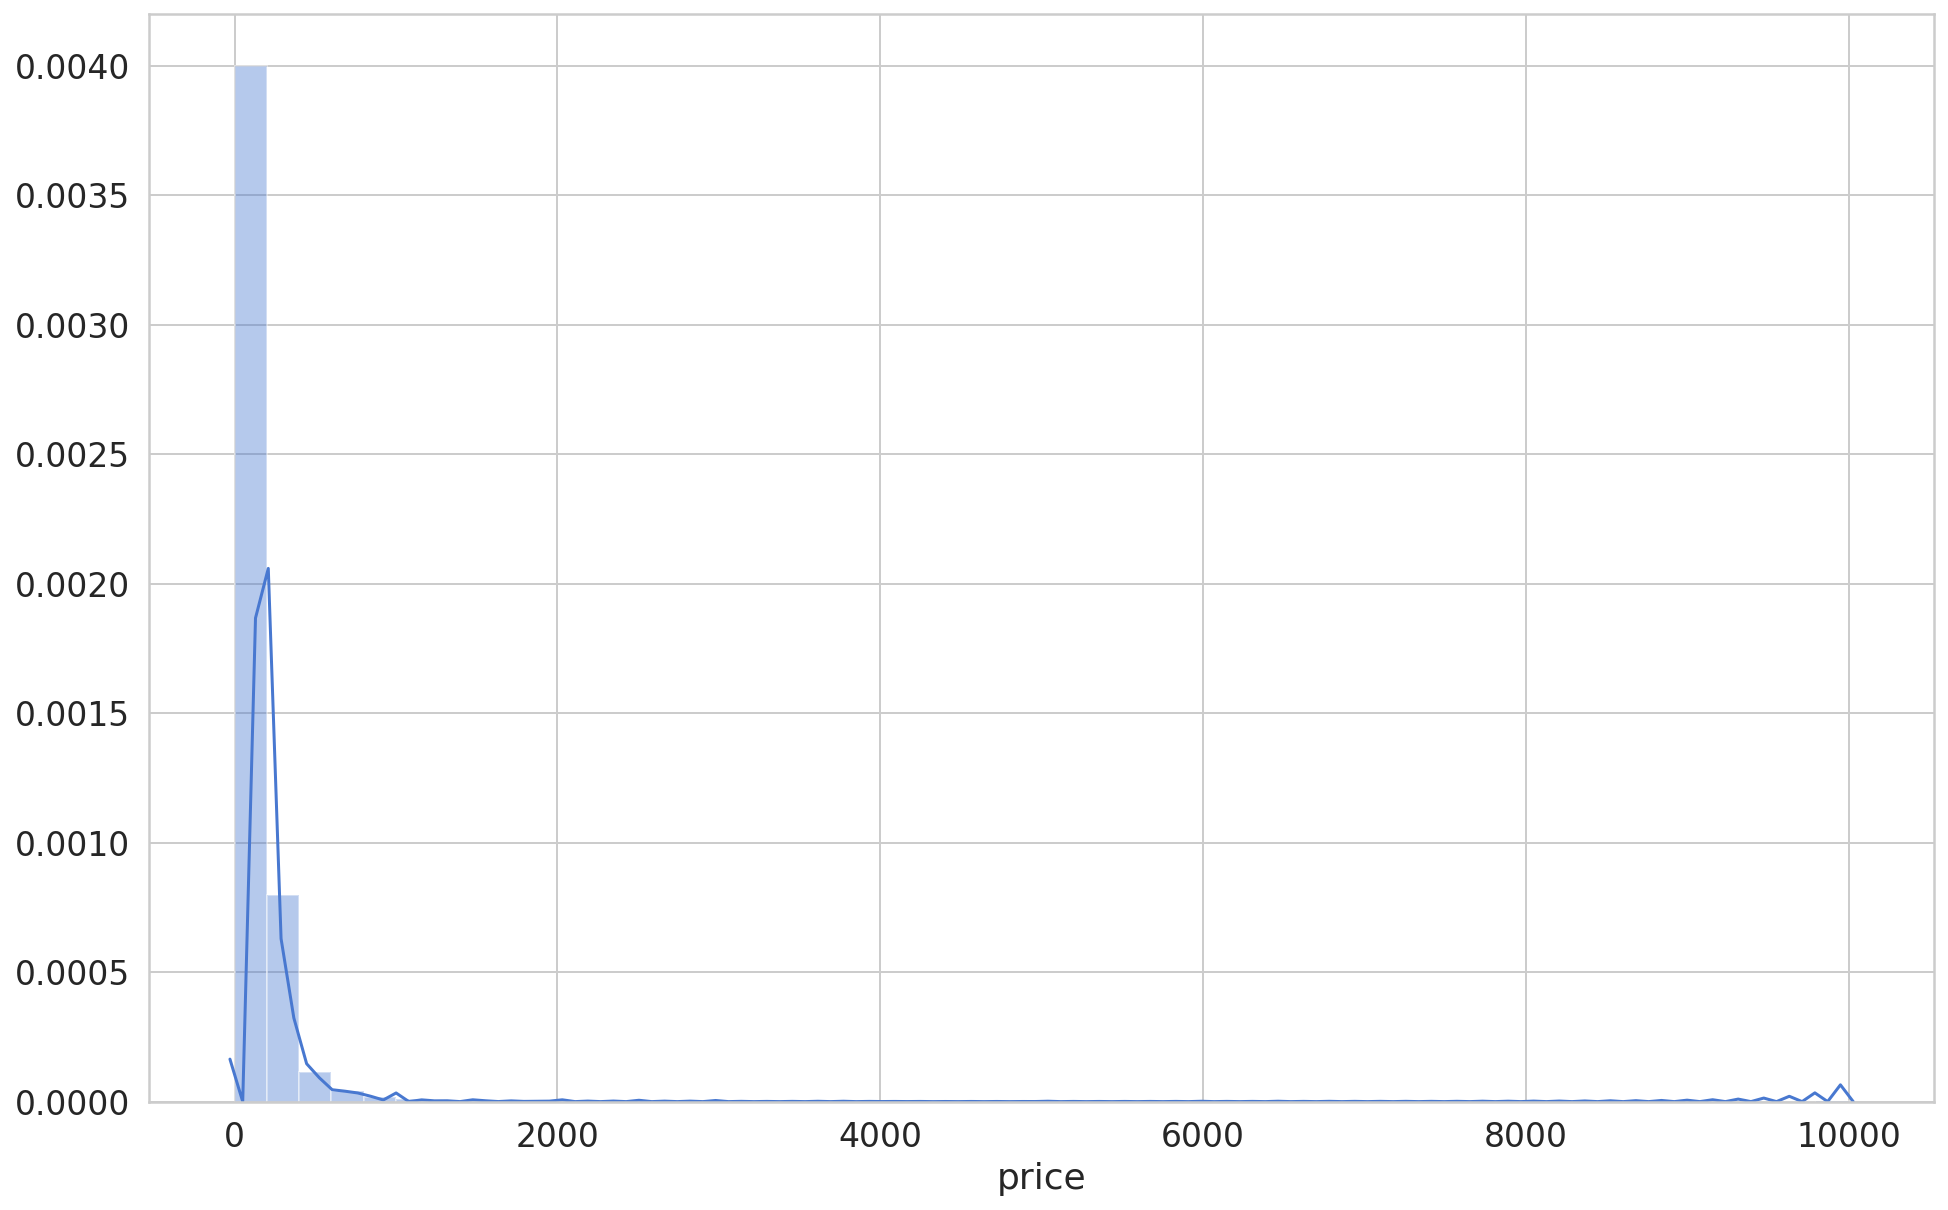

In [5]:
sns.distplot(df.price)

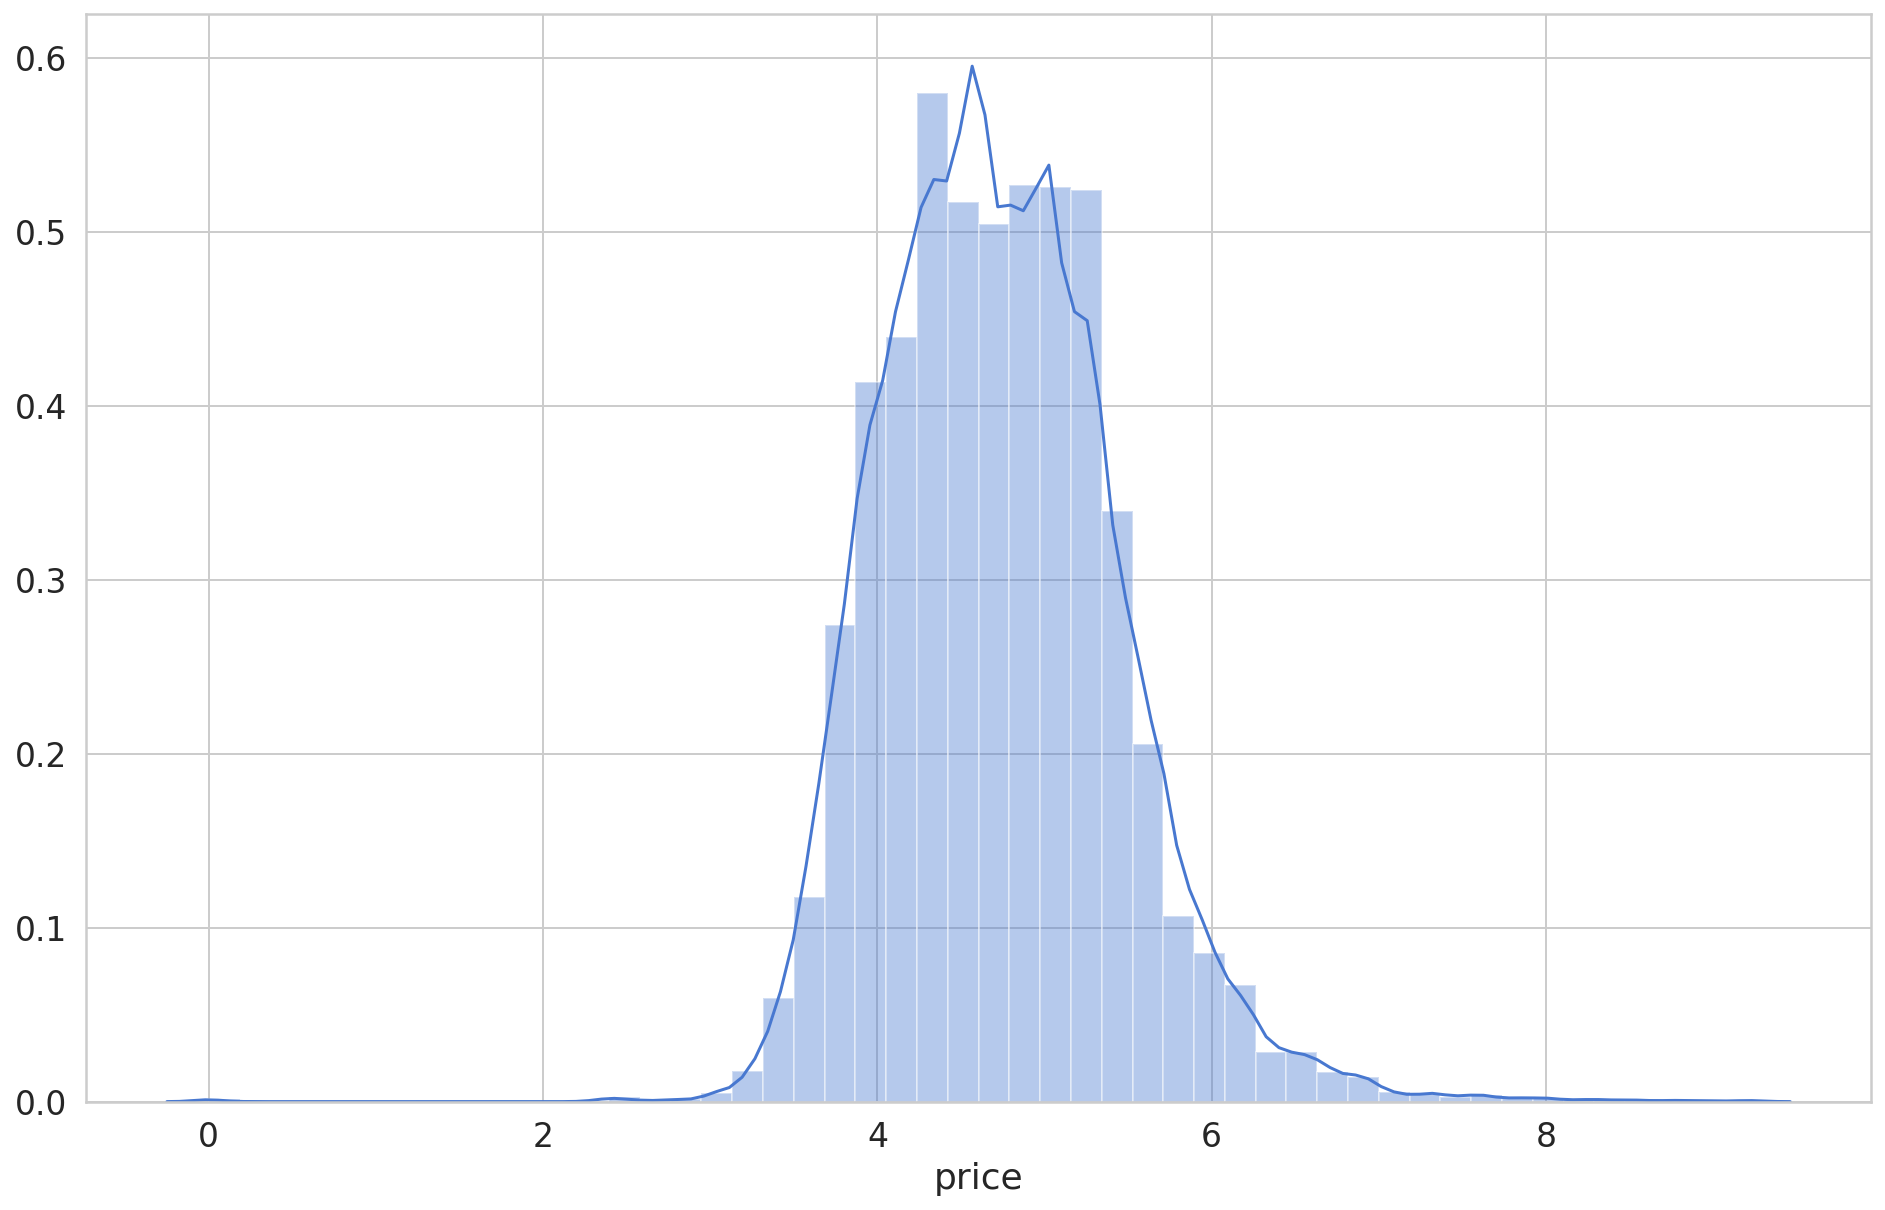

In [7]:
sns.distplot(np.log1p(df.price))

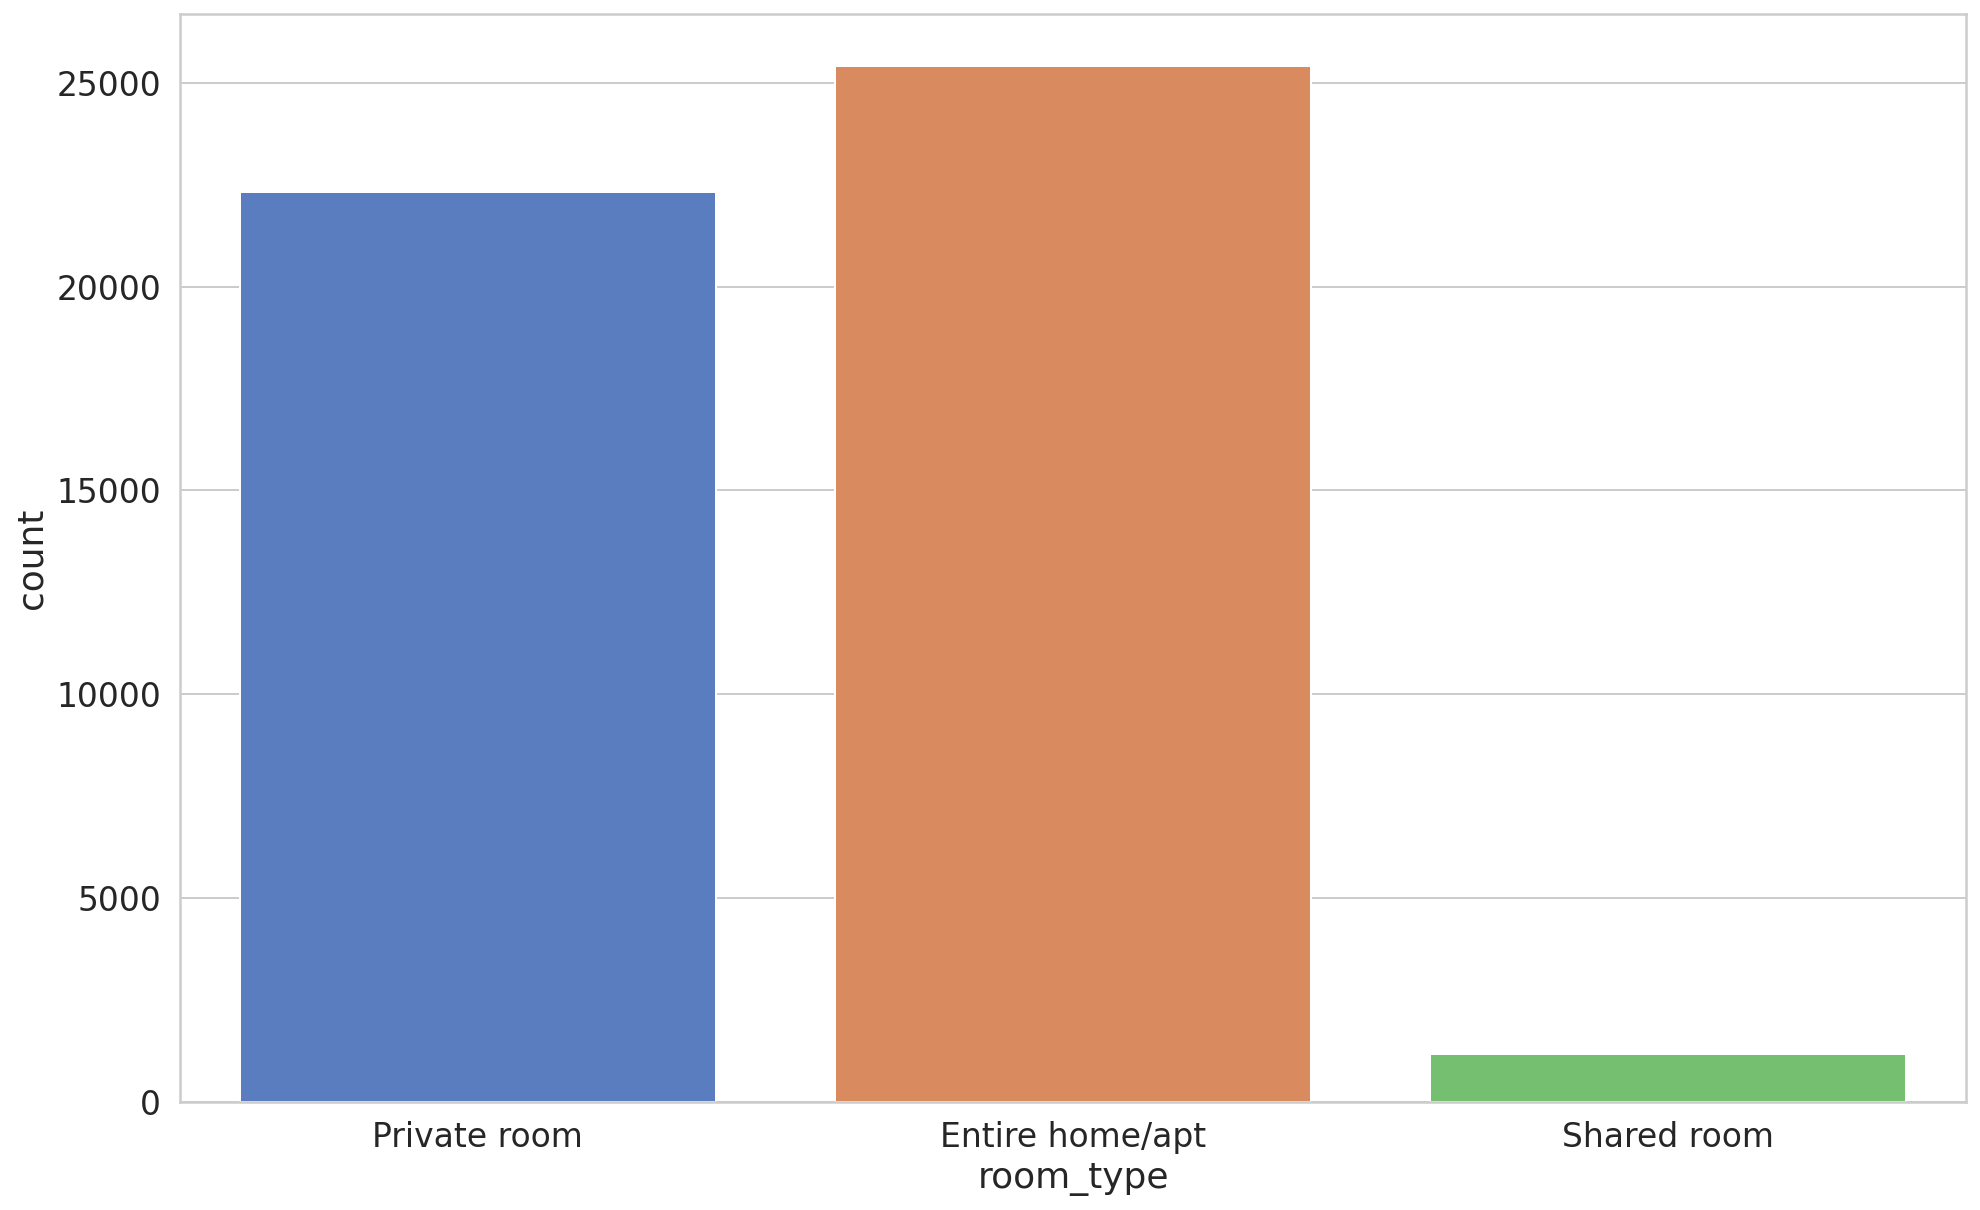

In [9]:
sns.countplot(x='room_type', data=df)

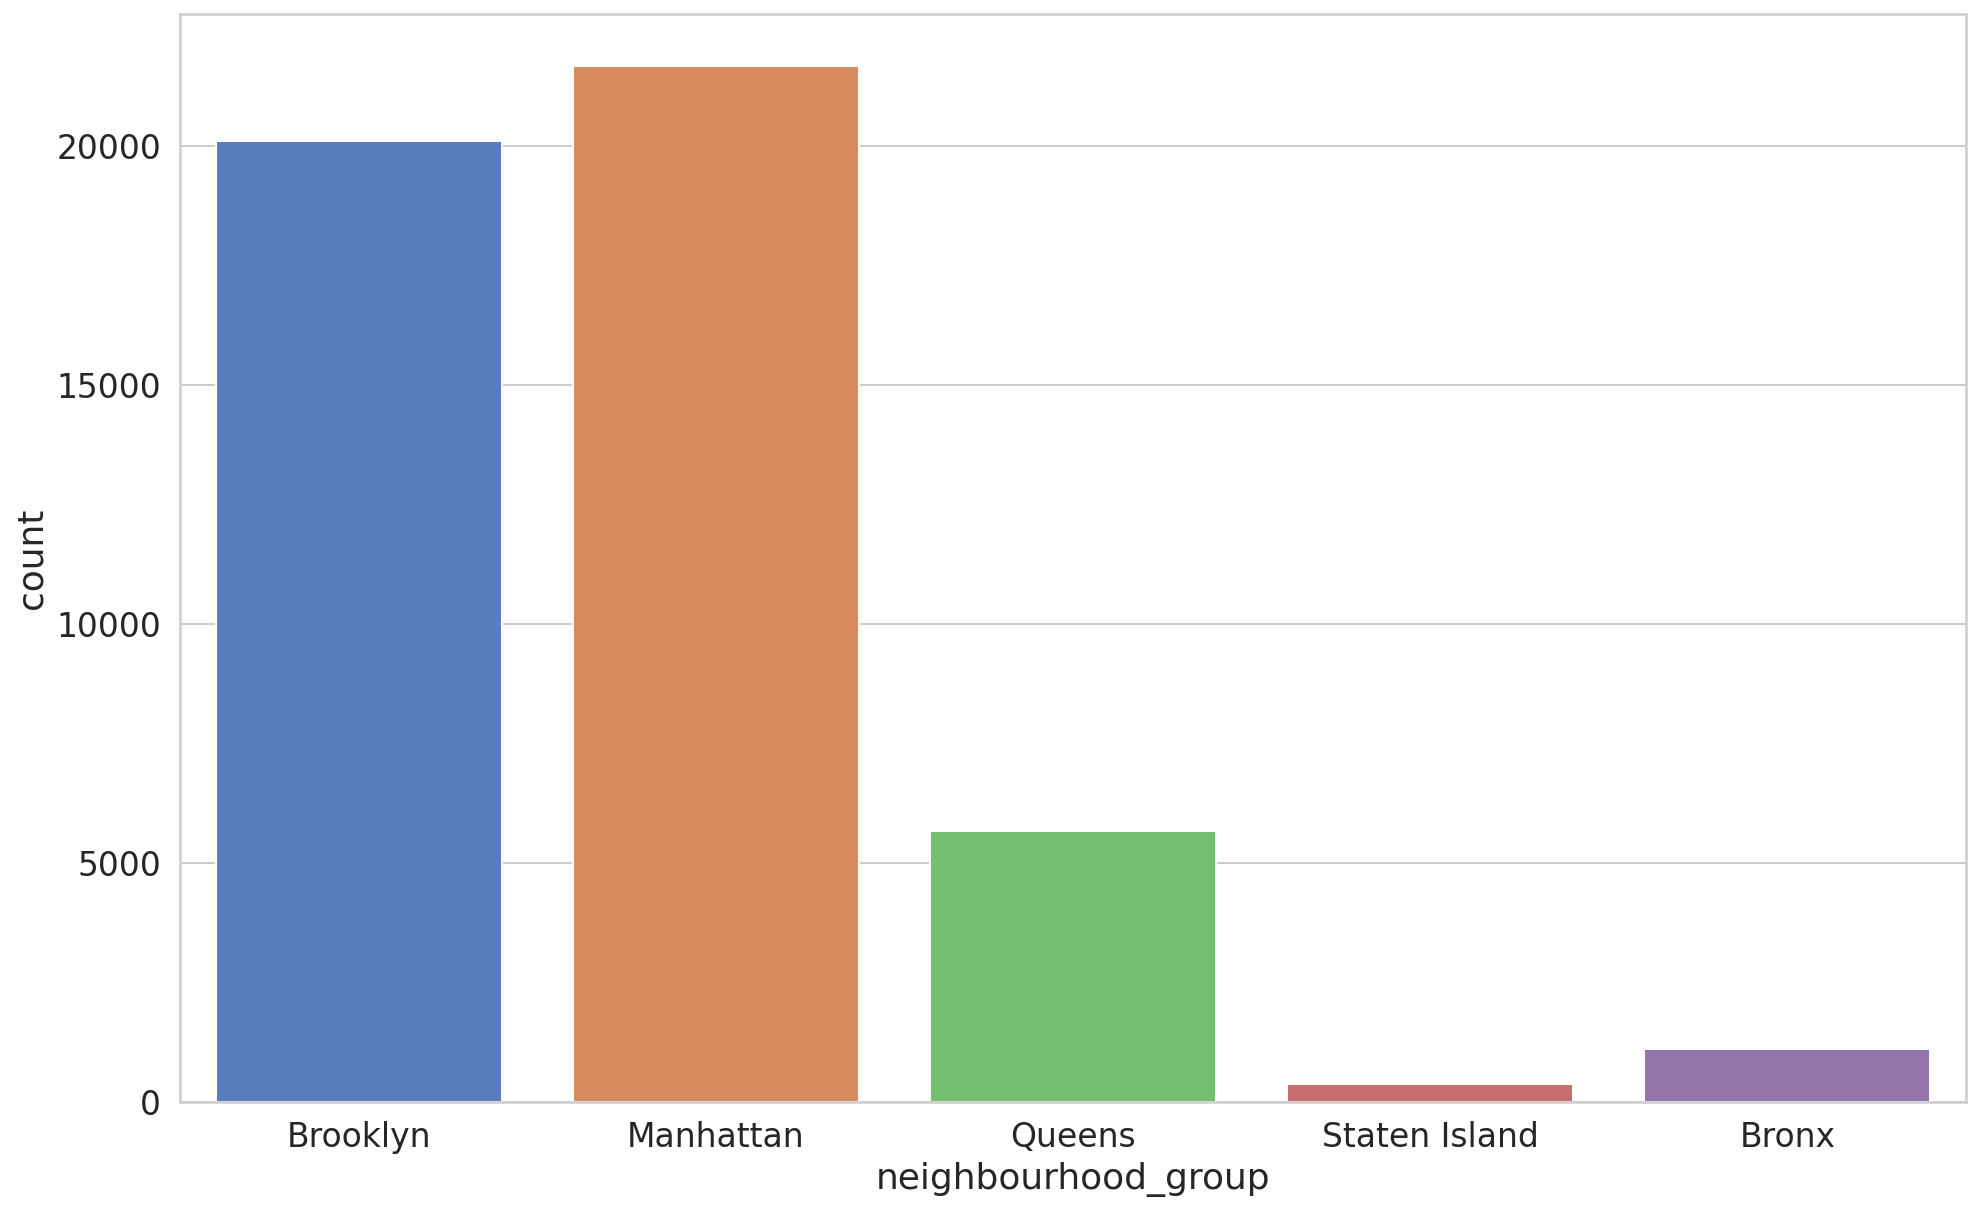

In [10]:
sns.countplot(x='neighbourhood_group', data=df)

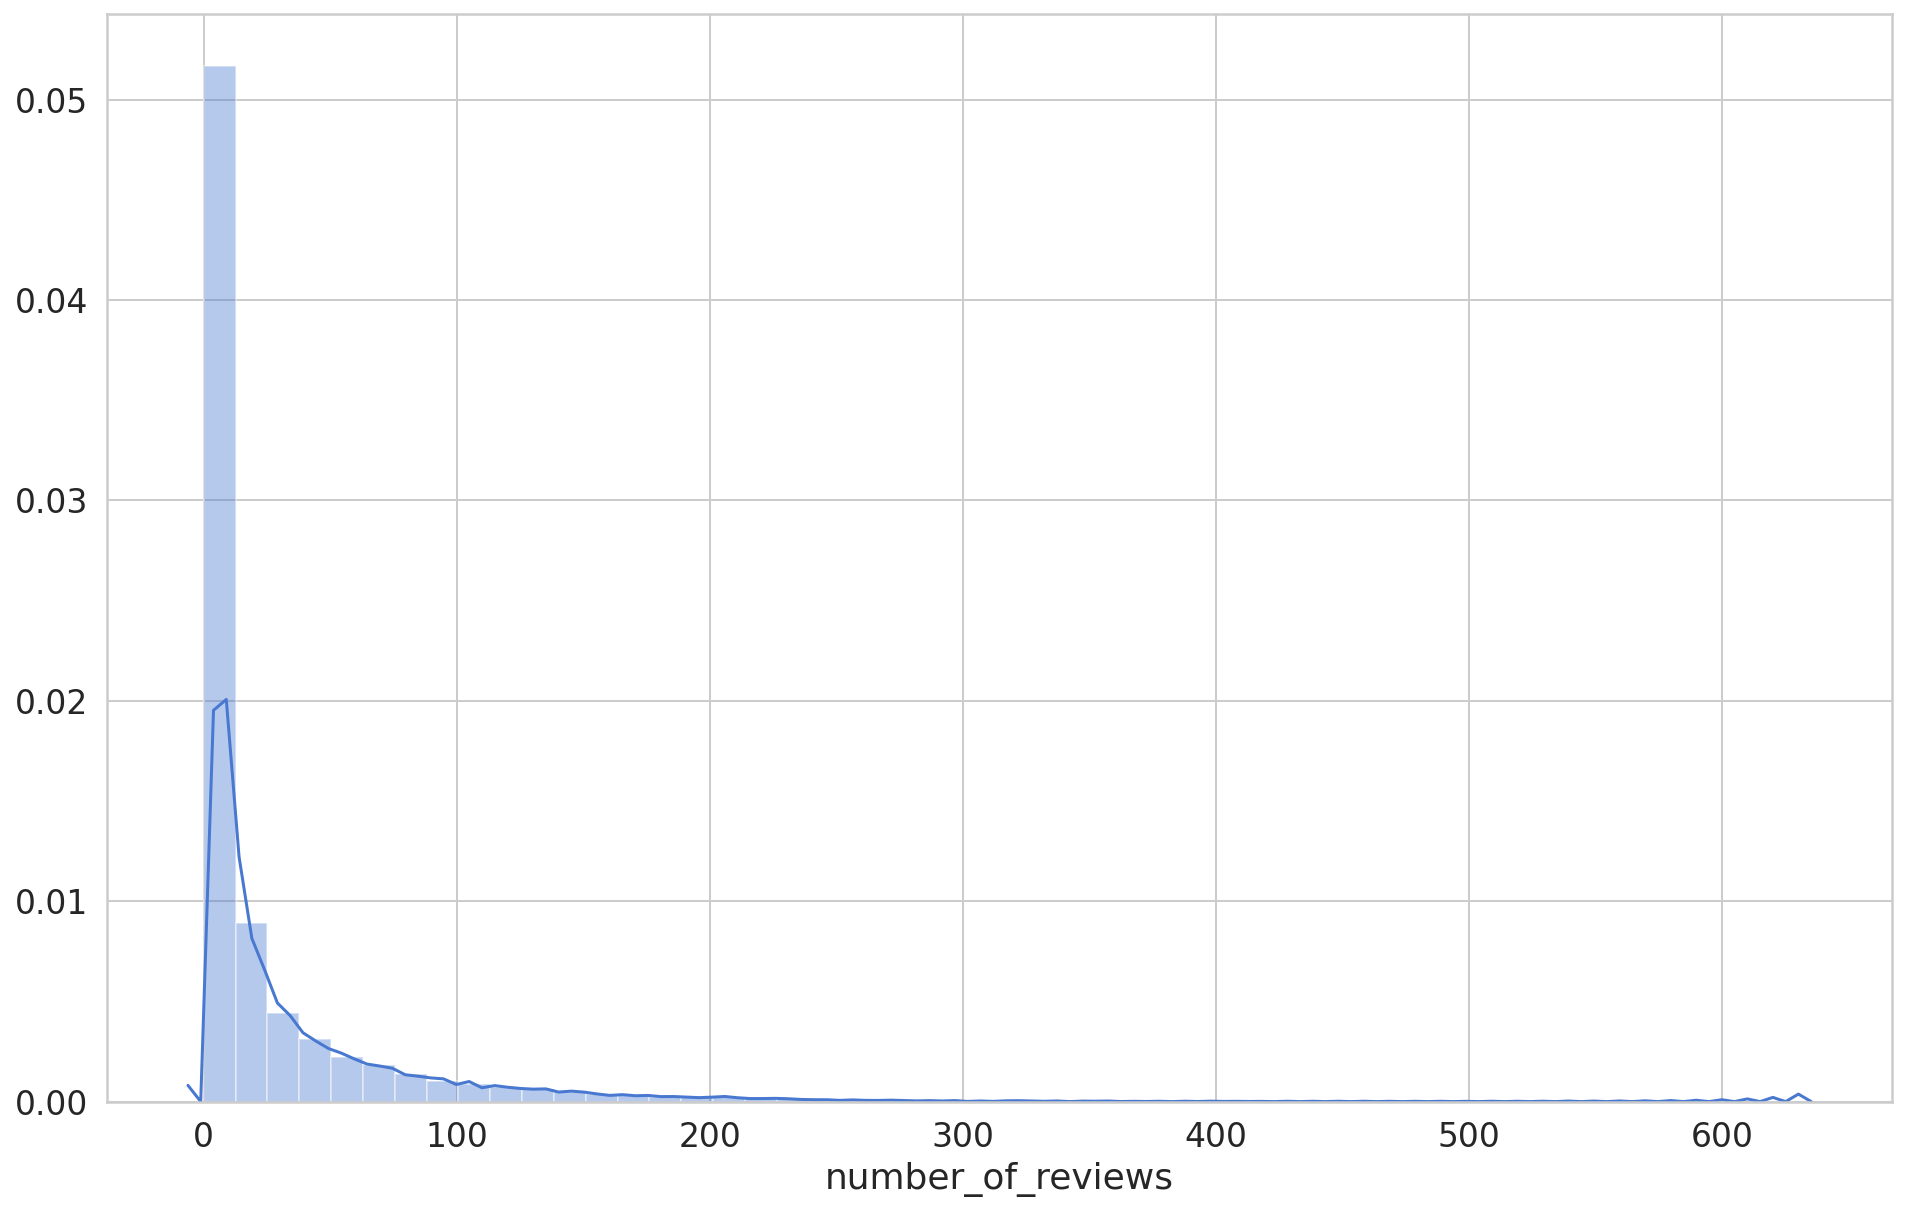

In [12]:
sns.distplot(df.number_of_reviews)

In [13]:
corr_matrix = df.corr()
price_corr = corr_matrix['price']
price_corr.iloc[price_corr.abs().argsort()]

id                                0.010619
host_id                           0.015309
reviews_per_month                -0.030608
latitude                          0.033939
minimum_nights                    0.042799
number_of_reviews                -0.047954
calculated_host_listings_count    0.057472
availability_365                  0.081829
longitude                        -0.150019
price                             1.000000
Name: price, dtype: float64